# A typical driver for climate-carbon cycle runs

In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib as mpl

from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.util.plot_base import PlotBase

In [2]:
myplt = PlotBase(palette='ipcc_wg1')

In [3]:
# Definitions of MCE variables and parameters
with open('mce/core/attributes.yml') as f1:
    mce_attrs = yaml.safe_load(f1)

In [4]:
list(mce_attrs)

['variables', 'parameters']

## Example scenarios

In [5]:
class ScenarioBellShaped(ScenarioBase):
    def init_process(self, *args, **kw):
        """Create bell-shaped emissions pathways
        based on Jones et al. (2019, https://doi.org/10.5194/gmd-12-4375-2019)
        """
        Period = 96
        CumulativeE = [750, 1000, 2000]
        Time = np.arange(0.5, 200.5, 1)

        for emis_size in CumulativeE:
            SD = Period / 6
            CE = emis_size / 0.997300204
            Mu = Period / 2
            Emissions = CE *(
                (1/(SD*np.sqrt(2*np.pi)))*np.exp(-0.5*(((Time-Mu)/SD)**2))
            )
            Emissions[Period:] = 0

            grp = self.file.create_group(
                'bell-shaped {} Gt C'.format(emis_size),
            )
            dset = grp.create_dataset('input/emis/time', data=Time)
            dset.attrs['units'] = 'yr'
            dset = grp.create_dataset('input/emis/CO2', data=Emissions)
            dset.attrs['units'] = 'Gt C yr-1'

In [6]:
ds = ScenarioBellShaped()

[2025-03-20 10:05:13 mce.core] INFO:in-memory file opened


In [7]:
ds()

['bell-shaped 1000 Gt C', 'bell-shaped 2000 Gt C', 'bell-shaped 750 Gt C']

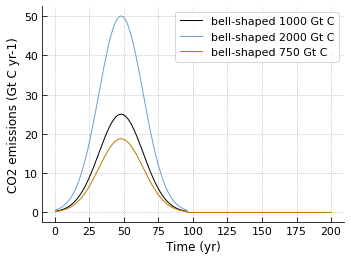

In [8]:
myplt.init_general()
ax = myplt(0)

iv = 0

for name in ds():
    din = ds.get_scenario(name)['emis']
    time = din['time']
    d1 = din['data'][:, iv]
    ax.plot(time, d1, label=name)

vn = din['variables'][iv]
attrs = din['attrs'][vn]
ax.legend()
ax.set_xlabel('Time (yr)')
ax.set_ylabel('{} emissions ({})'.format(vn, attrs['units']))
ax.grid()

## Driver for CO2-only runs

In [9]:
class Driver(DriverBase):
    def emis_co2_in(self, t):
        """Distinguish AFOLU emissions from FFI emissions
        based on a given scenario

        AFOLU=Agriculture, Forestry and Other Land Use
        FFI=Fossil Fuel combustion and Industrial processes

        Parameters
        ----------
        t
            Time point in year

        Returns
        -------
            Emission rates in Gt C yr-1 from FFI and AFOLU
            and cumulative emissions in Gt C from AFOLU
            at the time point
        """
        # AFOLU emissions are not considered in this case
        emis = {'AFOLU': 0.}
        ecum = {'AFOLU': 0.}

        is_cdrv = self.save['ocean']['is_cdrv']

        if not is_cdrv:
            # emission-driven runs
            din = self.din['emis']
            emis['FFI'] = din['interp'](t)[0]

        return emis, ecum

    def conc_co2_in(self, t):
        """Evaluate CO2 concentration based on a given scenario

        Parameters
        ----------
        t
            Time point in year

        Returns
        -------
            CO2 concentration in ppm at the time point
        """

        din = self.din['conc']
        return din['interp'](t)[0]

    def conc_co2_full_in(self):
        """Get time series of input CO2 concentration

        Returns
        -------
            Time series of CO2 concentration in ppm
            from a given scenario
        """
        din = self.din['conc']
        return din['data'][:, 0]

    def erf_in(self, t, y):
        """Evaluate forcing based on a given scenario

        Parameters
        ----------
        t
            Time point in year
        y
            Value of each prediction variable at the time point

        Returns
        -------
            Forcing in W m-2 at the time point
        """
        is_cdrv = self.save['ocean']['is_cdrv']

        if is_cdrv:
            cco2 = self.conc_co2_in(t)

        else:
            takj = self._getta(y)
            tas = takj[0, :].sum()

            coc = y[self.map_y['ocean']]
            model = self.ocean
            hls = model.parms.hlk[0]
            catm = model.partit(coc[0], hls, tas)
            cco2 = catm * model.parms.alphaa + model.parms.cco2_pi

        return self.forcing.c2erf(cco2)

## Conduct emission-driven runs

In [10]:
name = 'bell-shaped 1000 Gt C'
din = ds.get_scenario(name)

In [11]:
din['emis']['time']

array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
        45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
        54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
        63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
        72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
        81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
        90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
        99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
       108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
       117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
       126.5, 127.5,

In [12]:
config = {comp: {} for comp in ['climate', 'ocean', 'land']}
config['ocean']['is_cdrv'] = False # it means emission-driven mode
drv = Driver(**config)

# The time points are not necessarily equally-spaced,
# but usually based on the scenario
time = din['emis']['time']
ret = drv.run(din, time)

In [13]:
list(ret)

['time', 'tas', 'thc', 'cbst', 'cco2', 'catm', 'coct']

In [14]:
for k in ret:
    if k == 'time':
        continue

    attrs = mce_attrs['variables'][k]
    print('{}: {} ({})'.format(k, attrs['long_name'], attrs['units']))

tas: Surface temperature change (K)
thc: Total heat content change (ZJ)
cbst: Accumulated total carbon over land (Gt C)
cco2: Atmospheric CO2 concentration (ppm)
catm: Excess carbon in the atmosphere (Gt C)
coct: Accumulated total carbon over ocean (Gt C)


In [15]:
# Output data can be stored in any hierarchy of HDF5 file
# contained in the scenario object
gout = ds.file.create_group(f'{name}/output/edrv')

for vn, d1 in ret.items():
    dset = gout.create_dataset(vn, data=d1)
    for k, v in mce_attrs['variables'].get(vn, {}).items():
        dset.attrs[k] = v

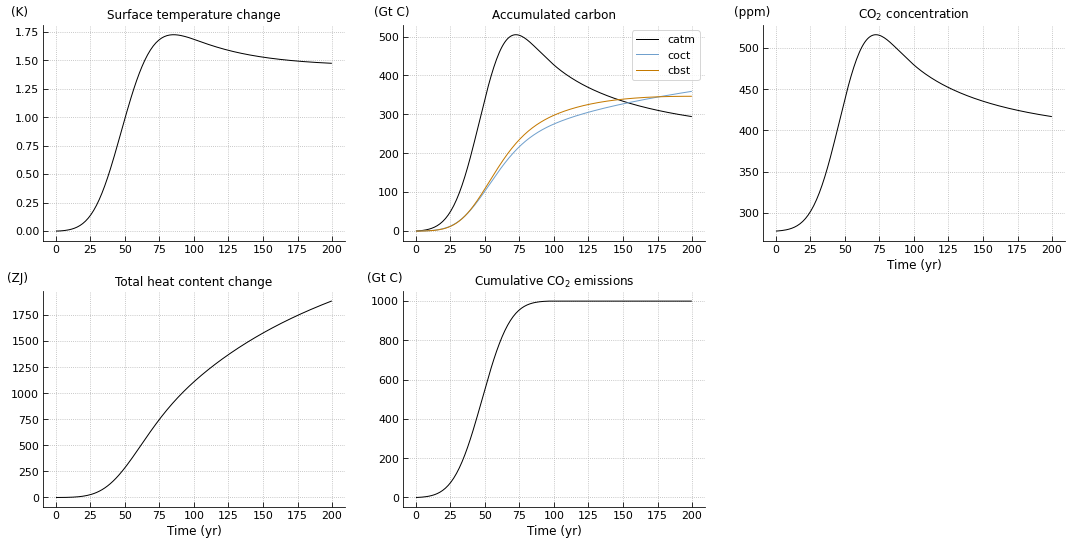

In [16]:
myplt.init_regular(5, col=3)
kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}
time = gout['time'][:]

ax = myplt(0)
vn = 'tas'
dset = gout[vn]
ax.plot(time, dset[:])
ax.set_title('Surface temperature change')
ax.set_ylabel('({})'.format(dset.attrs['units']), **kw_ylabel)

ax = myplt(1)
for vn in ['catm', 'coct', 'cbst']:
    dset = gout[vn]
    ax.plot(time, dset[:], label=vn)

ax.legend()
ax.set_title('Accumulated carbon')
ax.set_ylabel('({})'.format(dset.attrs['units']), **kw_ylabel)

ax = myplt(2)
vn = 'cco2'
dset = gout[vn]
ax.plot(time, dset[:])
ax.set_title('CO$_2$ concentration')
ax.set_ylabel('({})'.format(dset.attrs['units']), **kw_ylabel)

ax = myplt(3)
vn = 'thc'
dset = gout[vn]
ax.plot(time, dset[:])
ax.set_title('Total heat content change')
ax.set_ylabel('({})'.format(dset.attrs['units']), **kw_ylabel)

ax = myplt(4)
d1 = 0.
for vn in ['catm', 'cbst', 'coct']:
    d1 += gout[vn][:]

ax.plot(time, d1)
ax.set_title('Cumulative CO$_2$ emissions')
ax.set_ylabel('({})'.format(gout[vn].attrs['units']), **kw_ylabel)

for n, ax in enumerate(myplt()):
    ax.grid()
    if n in [2, 3, 4]:
        ax.set_xlabel('Time (yr)')

In [17]:
# Conduct the other scenarios
for name, grp in ds.file.items():
    if 'output' in grp:
        print(f'skip {name}')
        continue

    print(name)
    din = ds.get_scenario(name)
    time = din['emis']['time']
    ret = drv.run(din, time)

    gout = grp.create_group('output/edrv')

    for vn, d1 in ret.items():
        dset = gout.create_dataset(vn, data=d1)
        for k, v in mce_attrs['variables'].get(vn, {}).items():
            dset.attrs[k] = v

skip bell-shaped 1000 Gt C
bell-shaped 2000 Gt C
bell-shaped 750 Gt C


## Conduct concentration-driven runs

In [18]:
# For each scenario, create 'conc' input category
# and copy time and cco2 from the previous emission-driven run

for name, grp in ds.file.items():
    gin = grp['input'].create_group('conc')

    dset_edrv = grp['output/edrv']['time']
    dset = gin.create_dataset('time', data=dset_edrv[:])
    dset.attrs['units'] = 'yr'

    dset_edrv = grp['output/edrv']['cco2']
    dset = gin.create_dataset('CO2', data=dset_edrv[:])
    dset.attrs['units'] = dset_edrv.attrs['units']

In [19]:
# Changed to concentratio-driven mode
config['ocean']['is_cdrv'] = True
drv = Driver(**config)

In [20]:
for name, grp in ds.file.items():
    print(name)
    din = ds.get_scenario(name)
    time = din['conc']['time']
    ret = drv.run(din, time)

    gout = grp.create_group('output/cdrv')

    for vn, d1 in ret.items():
        dset = gout.create_dataset(vn, data=d1)
        for k, v in mce_attrs['variables'].get(vn, {}).items():
            dset.attrs[k] = v

bell-shaped 1000 Gt C
bell-shaped 2000 Gt C
bell-shaped 750 Gt C


In [21]:
# Difference between the concentration-driven and emission-driven runs
# cco2 is not included in the results from the concentration-driven run 
name = 'bell-shaped 1000 Gt C'
(
    pd.DataFrame({
        k: v[:] for k, v in ds.file[f'{name}/output/cdrv'].items()
    }).set_index('time')
    -
    pd.DataFrame({
        k: v[:] for k, v in ds.file[f'{name}/output/edrv'].items()
    }).set_index('time')
)

,catm,cbst,cco2,coct,tas,thc
time,,,,,,
0.5,0.000000e+00,0.000000,NaN,0.000000,0.000000,0.000000
1.5,0.000000e+00,0.000160,NaN,0.000079,0.000005,0.000354
2.5,-2.908784e-14,0.000354,NaN,0.000180,0.000008,0.000741
3.5,-3.264056e-14,0.000574,NaN,0.000301,0.000011,0.001182
4.5,-4.840572e-14,0.000824,NaN,0.000443,0.000014,0.001690
...,...,...,...,...,...,...
195.5,0.000000e+00,0.001290,NaN,0.001899,0.000004,0.008739
196.5,0.000000e+00,0.001279,NaN,0.001895,0.000004,0.008725
197.5,-5.684342e-14,0.001269,NaN,0.001890,0.000004,0.008711


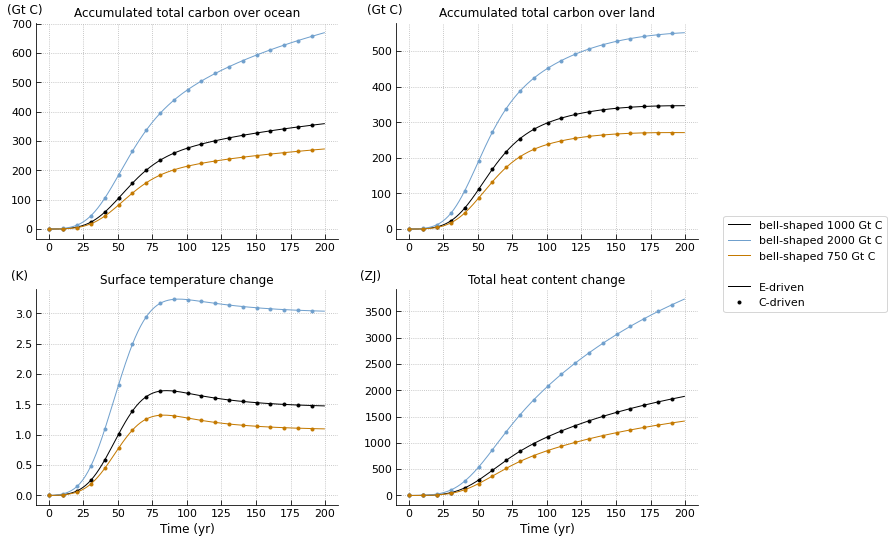

In [22]:
myplt.init_regular(4, col=2)

kw_ylabel = {
    'rotation': 'horizontal',
    'x': 0., 'y': 1.03, 'ha': 'left', 'va': 'bottom',
}
kw_plot_edrv = {'ls': '-'}
kw_plot_cdrv = {'ls': 'None', 'marker': '.'}
handles_common = [
    mpl.lines.Line2D([], [], color=f'C{i}')
    for i, name in enumerate(ds())
] + [
    mpl.patches.Patch(alpha=0, linewidth=0), # empty handle
    mpl.lines.Line2D([], [], color='k', **kw_plot_edrv),
    mpl.lines.Line2D([], [], color='k', **kw_plot_cdrv),
]
labels_common = ds() + ['', 'E-driven', 'C-driven']

for ax, vn in zip(myplt(), ['coct', 'cbst', 'tas', 'thc']):
    attrs = mce_attrs['variables'][vn]

    for i, name in enumerate(ds()):
        color = f'C{i}'
        gout = ds.file[f'{name}/output/edrv']
        ax.plot(
            gout['time'][:], gout[vn][:],
            color=color, **kw_plot_edrv,
        )
        gout = ds.file[f'{name}/output/cdrv']
        ax.plot(
            gout['time'][::10], gout[vn][::10],
            color=color, **kw_plot_cdrv,
        )

    ax.set_ylabel('({})'.format(attrs['units']), **kw_ylabel)
    ax.set_title(attrs['long_name'])
    ax.grid()

for ax in myplt(2, 3):
    ax.set_xlabel('Time (yr)')

_ = myplt.figure.legend(
    handles_common, labels_common,
    loc='center left',
    bbox_to_anchor=myplt.get_fig_position_relto_axes((1.03, 0.5)),
)

In [23]:
ds.close()

[2025-03-20 10:13:19 mce.core] INFO:in-memory file closed
